# Time Series Final Report  
## Studying Google Trends and adspend data for the The Home Depot 
****
Neven Grgic <br>
APRD 6343 <br>
March 14, 2018 <br>
University of Colorado-Boulder <br>
****
To begin, we will load all of our necessary packages, read in our Google Trends data, and take a glance at how our data looks graphically. 

In [1]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as pyplot
import pandas as pd 
import numpy as np
import holidays
from statsmodels.tsa import seasonal
from statsmodels.tsa import stattools
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

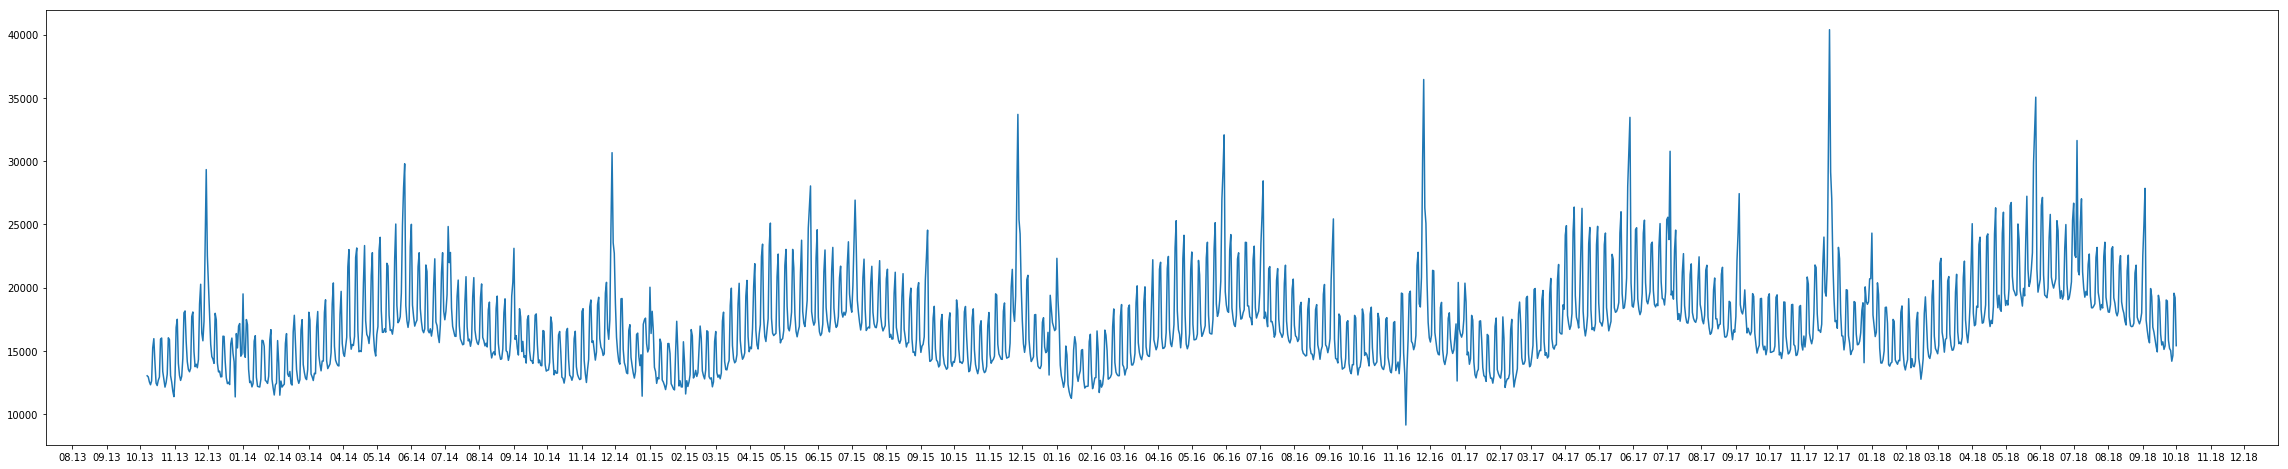

In [2]:
#read in the data and set 'period' to be a datetime object and the index. Also remove unecessary columns
homedepot = pd.read_csv('homedepot.googletrends.csv', parse_dates = ['period'])
homedepot['period'] = homedepot['period'].dt.date
homedepot.set_index('period', inplace = True)

homedepot.drop(["Unnamed: 0", "date"], axis = 1, inplace = True) 

#Plot the data to begin to understand it
dimensions = (40,8)
fig, ax = pyplot.subplots(figsize=dimensions)

#set up dates so that we can look at the month and year on the graph easily
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearmonth = mdates.DateFormatter('%m.%y')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearmonth)

_ = ax.plot(homedepot.index, homedepot['value'])

## Our first plot of the time series
It is already apparent that Home Depot sees an increase in Google searches during the spring and summer months and a decrease in Google searches in the fall and winter months. This makes sense as people tend to take on home improvement projects during the spring and summer. It can also be seen that there are some spikes annually, but we will get a better look at these in our plots later on.  

***
## Stationarity
Now let's check if the data is stationary to confirm that the assumptions of time series analysis are being met. Keep in mind that the null hypothesis of this test is that the data is not stationary.

In [3]:
#First, we check the raw google trends data for stationarity
adf_result = stattools.adfuller(homedepot['value'])
print()
print('Stationary test p-value for Google Trends values:', '           ', adf_result[1])

#Now we check the differenced data for stationarity
adf_result = stattools.adfuller(homedepot['onediffvalue'].iloc[1:])
print('Stationary test p-value for Differenced Google Trends values:', adf_result[1])


Stationary test p-value for Google Trends values:             0.00027225411246229483
Stationary test p-value for Differenced Google Trends values: 3.368221650677844e-23


Both the raw Google Trends values as well as the differenced Google Trends values are stationary (p-value is < 0.05), however  the p-value of the differenced data is much smaller, as we would expect when using differenced values. Because of the significance of the differenced data relative to the raw data, we will move forward with the differenced data.
***
## Decomposing the time series
Before we can move forward with the differenced data though, we need to decompose the time series to further understand the seasonalities and general trend of the data. Based on our graph above, we will look at seasonality annually with an additive model, which is sensible since promotions and long weekends happen annually and there doesn't appear to be an exponential relationship. Below we plot the time series, the general trend, the seasonality, and the error to get an idea of what they each look like graphically. 

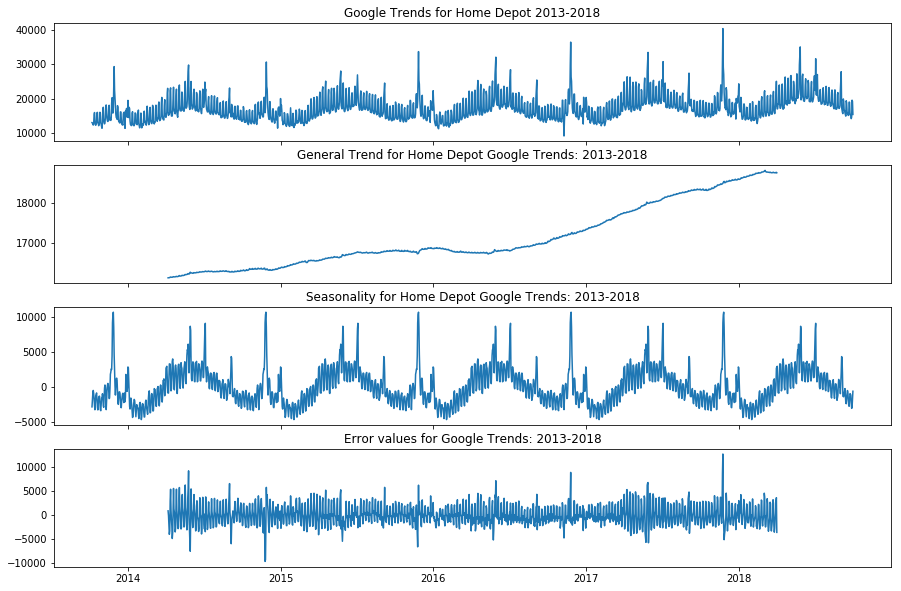

In [4]:
decompose_model = seasonal.seasonal_decompose((homedepot['value']).tolist(), freq=365, model = 'additive')
dir(decompose_model)

dimensions = (15,10)
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(4, figsize=dimensions, sharex = 'all')
_ = ax1.plot(homedepot.index, homedepot['value'])
_ = ax2.plot(homedepot.index, decompose_model.trend)
_ = ax3.plot(homedepot.index, decompose_model.seasonal) 
_ = ax4.plot(homedepot.index, decompose_model.resid)

_ = ax1.set_title("Google Trends for Home Depot 2013-2018")
_ = ax2.set_title("General Trend for Home Depot Google Trends: 2013-2018")
_ = ax3.set_title("Seasonality for Home Depot Google Trends: 2013-2018")
_ = ax4.set_title("Error values for Google Trends: 2013-2018")

These graphs give us a good overall picture of each compenent, but lets also zoom in on the seasonality graph for just a single year get a better look.  

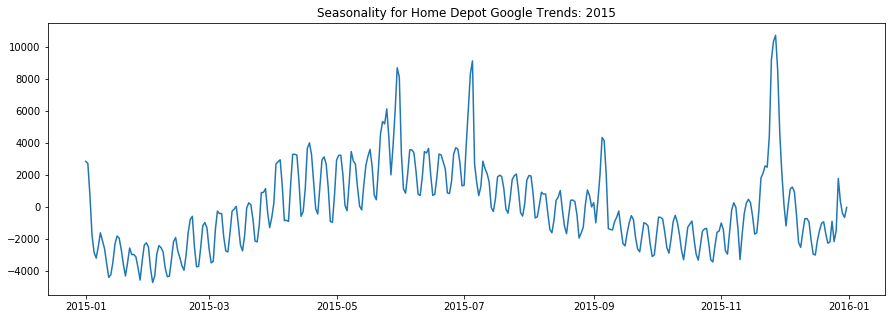

In [5]:
#pull out one year of the seasonality to look at in more depth and add to our dataframe
homedepot['seasonal'] = decompose_model.seasonal  #this gives use the deviation from the average for each day
startdate = pd.to_datetime('2015-01-01').date()
enddate = pd.to_datetime('2015-12-31').date()

#set the year we want to plot from our dataframe
oneyear = homedepot.loc[startdate:enddate]

#make the plot
dimensions = (15,5)
fig, ax1 = pyplot.subplots(figsize=dimensions)
_ = pyplot.plot(oneyear.index, oneyear.seasonal)
_ = ax1.set_title("Seasonality for Home Depot Google Trends: 2015")

## Summarizing Our Graphs
In looking at the graphs, the general trend of our data is positive and clearly there is an annual seasonality with two spikes in the summer months, a spike on labor day, and a spike around Black Friday and Christmas/New Years. More broadly, the annual seasonality shows a rise in the first half of the year and a fall in the second half of the year.  

It seems that the seasonality is being driven both by the product and the consumer. Promotions that the Home Depot are having as well as when the consumers have free time seem to shape the seasonality. Common weekends for home improvement projects like memorial day and labor day seem to cause large increases and common major holidays when Home Depot runs promotions such as Independence day, Black Friday, and Christmas also drive increases in search volume. The broader trend of increasing search volume in the first half of the year and decreasing search volume in the second half of the year is likely a result of consumers doing less projects during the winter months and also Home Depot having less promotions during these months. There appears to be a weekly seasonality also, likely increasing searches on the weekends. We will look at this in more depth in the next part of this analysis, but this aligns with the idea of consumer's free time driving Google searches for Home Depot. While this graph is overfit, the broad seasonalities are clear. 
***
## Time Series with Facebook Prophet
Now we will look to forecast the next year of Google Trends data for Home Depot using Facebook Prophet.

In [6]:
import warnings
warnings.simplefilter('ignore')

#First, create the dataframe to feed to fb prophet
prophetdataframe = pd.DataFrame()
prophetdataframe['ds'] = homedepot.index
prophetdataframe['y'] = homedepot['value'].tolist()

#now we fit and run the model
m = Prophet(daily_seasonality = False)
m.fit(prophetdataframe)

#and use the model to make future predictions
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)

## Now that we have fit a preliminary model using Prophet, we will examine the error.

           Total Model Error: 1824045.11
           Mean Absolute Error: 1001.67
Standard Deviation of the Google Trends Value: 3557.75


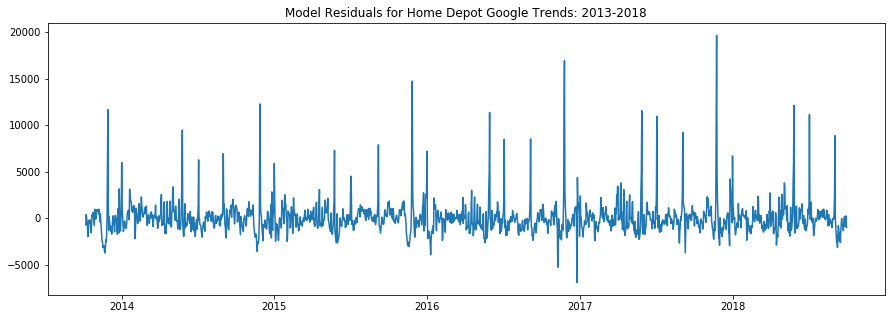

In [7]:
#make a dataframe of the residuals
erroranalysis = m.predict(prophetdataframe)
erroranalysis['value'] = prophetdataframe['y']
erroranalysis['residuals'] = erroranalysis['value'] - erroranalysis['yhat'] 
erroranalysis['absoluteresiduals'] = abs(erroranalysis['residuals'])

#calculate, print, and graph different levels of the error
totalerror = erroranalysis['absoluteresiduals'].sum()
print('========================================================')
print('           Total Model Error:', round(totalerror, 2))
print('========================================================')
print('           Mean Absolute Error:', round(totalerror/len(erroranalysis),2))
print('========================================================')
print('Standard Deviation of the Google Trends Value:', round(erroranalysis['value'].std(), 2))

dimensions = (15,5)
fig, ax1 = pyplot.subplots(figsize=dimensions)
_ = pyplot.plot(erroranalysis['ds'], erroranalysis['residuals'])
_ = ax1.set_title("Model Residuals for Home Depot Google Trends: 2013-2018")

Examining the errors we calculated above, the model looks to be doing a pretty good job as the mean absolute error is less than 1/3 of the standard deviation of the target variable. When we look at our residual plot though, there are several spikes each year that appear to be in a somewhat recurring pattern. If we can find a better way to account for these dates, we can likely get an even more accurate model. Below we will account for holidays and trailing/leading days of certain holiday weekends, since these are popular times for sales and for consumers to complete home improvement projects.   

    Total Model Error: 1237072.2905675229
    Mean Absolute Error: 679.3367877910614


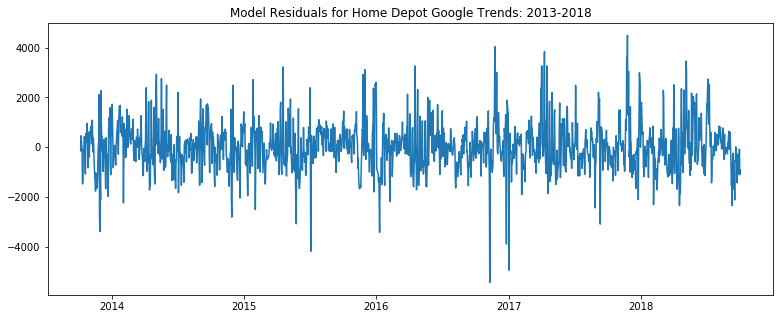

In [8]:
#make a list of annual holidays
goodholidays = []
for date, name in sorted(holidays.US(years = 2014).items()):
    goodholidays.append(name)
    
#remove the holidays that we do not feel the leading/trailing days are important for home depot
goodholidays.remove("Martin Luther King, Jr. Day")
goodholidays.remove("Columbus Day")
goodholidays.remove("Veterans Day")

#make a dataframe to store the holidays and the number of leading/trailing days in
sales = pd.DataFrame(columns = ['holiday', 'ds', 'lower_window', 'upper_window'])

#Go through each years holidays and note how many leading/trailing days we should include. 
#Added in saturdays and sundays to include just the friday/monday preceeding or following.
#Also added logic to ensure that the day before and after christmas is always included as a holiday 
for year in range(2013,2021):
    for date, name in sorted(holidays.US(years = year).items()):
        lower_window = 0
        upper_window = 0
        if name in goodholidays:
            dayoftheweek = date.weekday()  #monday is 0, sunday is 6
            if dayoftheweek == 0:
                lower_window = -2
                if name == 'Christmas Day':
                    upper_window = 1
            if dayoftheweek == 1:
                lower_window = -3
            if dayoftheweek == 2 and name == 'Christmas Day':
                lower_window = -1
                upper_window = 1
            if dayoftheweek == 3:
                upper_window = 3
                if name == 'Christmas Day':
                    lower_window = -1
            if dayoftheweek == 4:
                upper_window = 2
                if name == 'Christmas Day':
                    lower_window = -1
            if dayoftheweek == 5:
                lower_window = -1
                upper_window = 1
            if dayoftheweek == 6:
                upper_window = 1
                lower_window = -1
            sales.loc[len(sales)] = [name, date, lower_window, upper_window] 

#add the holidays/weekends we just created as well as the US holidays themselves which Prophet will find
m = Prophet(holidays=sales, daily_seasonality = False)
m.add_country_holidays(country_name='US')

#fit the model and make future predictons
m.fit(prophetdataframe)
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)

#make a dataframe to assess the error of our new model
erroranalysis = m.predict(prophetdataframe)
erroranalysis['value'] = prophetdataframe['y']
erroranalysis['residuals'] = erroranalysis['value'] - erroranalysis['yhat'] 
erroranalysis['absoluteresiduals'] = abs(erroranalysis['residuals'])
totalerror = erroranalysis['absoluteresiduals'].sum()
print('===================================================')
print('    Total Model Error:', totalerror)
print('===================================================')
print('    Mean Absolute Error:', totalerror/len(erroranalysis))
print('===================================================')

#plot the residuals
dimensions = (13,5)
fig, ax1 = pyplot.subplots(figsize=dimensions)
_ = pyplot.plot(erroranalysis['ds'], erroranalysis['residuals'])
_ = ax1.set_title("Model Residuals for Home Depot Google Trends: 2013-2018")

#erroranalysis.to_csv('errors.csv') #save to a csv to examine some of the residuals in more depth

By adding in holidays and leading/trailing days, we were able to reduce the MAE by 32.18%! We now have an MAE that is less than 1/5 of the standard error of the target variable, indicating a pretty strong model. While there are still spikes in the residual plot, they no longer appear to be systematic. Also, looking at the y-axis, the largest residuals are considerably smaller than they were before. 
***
## Examining Outliers
Now we examine some of the outliers that remain to better understand the largest spikes in our residual plot. 

In [9]:
print('===========================')
print('     Top 10 Residuals')
print('===========================')
print(erroranalysis.nlargest(10, 'absoluteresiduals')[['ds','residuals']].to_string(index=False))

     Top 10 Residuals
        ds    residuals
2016-11-09 -5434.996581
2017-01-01 -4943.264895
2017-11-24  4489.422266
2015-07-04 -4183.485331
2016-11-23  4038.118550
2016-12-25 -3893.511818
2017-04-09  3841.576036
2017-11-22  3591.340725
2018-05-05  3458.217485
2016-01-10 -3425.947669


Our largest residual is from the day following the 2016 U.S. Presidential election, so it seems that maybe people's attention was placed there and abnormally low levels of search volume were recorded as a result. Most of the other dates in the top 10 residuals are related to holidays being under or over estimated. Even though the Prophet model accounts for holidays, there is still a lot of variation in google search volume for holidays, which makes them hard to capture with high accuracy. The April and May dates I expect are a result of unseasonably warm weather, leading to more home improvement activities and increased Home Depot Google searches. Reviewing some weather data confirmed this to be a plausible explanation as the US weather on these dates was generally favorable with high temperatures above the general averages of most US cities and the majority of the US seeing no precipitation. This just leaves January 10, 2016, and it is hard to explain why search volume is much lower than our model predicts on this day. Google searches for Home Depot specific to this day and the April and May days noted before do not return anything noteworthy, and the weather doesn't appear to be out of the norm for that time of year on a national scale. Looking for major events related to these dates doesn't return anything that would seem connected with an increase or decrease in Home Depot search volume either. Sometimes unexpected variation can happen, which is part of the challenge of time series analysis. Overall, the days surrounding Thanksgiving tend to be difficult to estimate, which makes sense since these are the most volatile days for search volume.  
***
## Plotting the Prophet Model
Now we can examine the plot of our time series and forecast as well as the trend, holiday effects, and seasonalities from our Prophet model. 

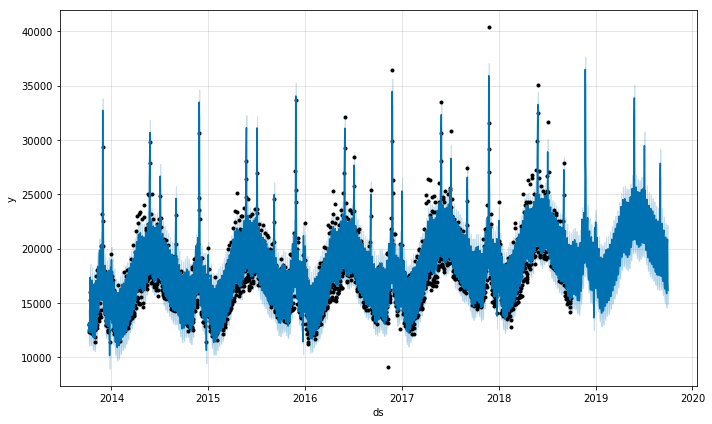

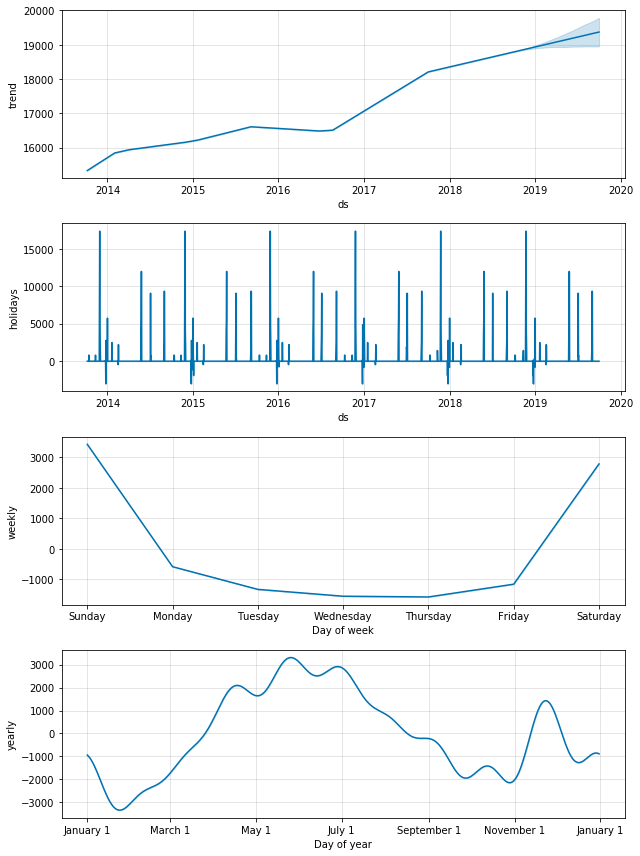

In [10]:
fig1 = m.plot(forecast)
fig = m.plot_components(forecast)

Examining our plots, we can see that we do a much better job of capturing holidays now and also that we have a positive trend with annual and weekly seasonalities. It is evident that the projected times of high interest are spring and summer months, as well as Black Friday and over the Christmas/New Year's holdiay (relative to the rest of the winter). Interest is lowest from dates following labor day to around the beginning of March, with the exception of Black Friday and Christmas/New Year's. 

## Moving on to Using Advertising Spending to Predict Google Search Volume
Now we examine various types of advertising spending and their relationship with Google Search Volume. First we grab our adspend data which we cleaned up before and test the stationarity of this data

In [11]:
#bring in our adspend data, set the index, and do some final cleaning
adspend_trends = pd.read_csv('adspend.googletrends.homedepot.weekly.csv', parse_dates=['FIXED TIME'])
adspend_trends.set_index('FIXED TIME', inplace = True)
adspend_trends = adspend_trends.drop(columns = ['onediffvalue', 'Unnamed: 0', 'TOTALdiff', 'valuediff'])

#create a dataframe to store the stationarity of each variable
stationarity = pd.DataFrame(columns = ['adspend_variable', 'p-value'])

#Test for the stationarity of each variable
for acolumn in list(adspend_trends):
    adf_result = stattools.adfuller(adspend_trends[acolumn])
    stationarity.loc[len(stationarity)] = [acolumn, round(adf_result[1], 6)]
print(stationarity.to_string(index = False))

adspend_variable   p-value
        CABLE TV  0.000000
       MAGAZINES  0.003826
  NAT SPOT RADIO  0.000232
      NATL NEWSP  0.000000
   NETWORK RADIO  0.000030
      NETWORK TV  0.000018
       NEWSPAPER  0.000000
         OUTDOOR  0.013740
         SPOT TV  0.000000
     SYNDICATION  0.259417
           TOTAL  0.000117
           value  0.001632


## All of our variables are currently stationary except for syndication. 
Below we difference the data and test for stationarity once again. 

In [12]:
#make a dataframe of the differenced values
adspend_trends_diff = pd.DataFrame()
for acolumn in list(adspend_trends):
    columnname = "%s_diff" % (acolumn)
    adspend_trends_diff[columnname] = adspend_trends[acolumn].diff(1)
    
#create a dataframe to store the stationarity
differenced_stationarity = pd.DataFrame(columns = ['adspend_variable', 'p-value'])

#Test for the stationarity of each variable
for acolumn in list(adspend_trends_diff):
    adf_result = stattools.adfuller(adspend_trends_diff[acolumn].iloc[1:])
    differenced_stationarity.loc[len(differenced_stationarity)] = [acolumn, round(adf_result[1], 6)]
print(differenced_stationarity.to_string(index = False))

    adspend_variable   p-value
       CABLE TV_diff  0.000000
      MAGAZINES_diff  0.000000
 NAT SPOT RADIO_diff  0.000000
     NATL NEWSP_diff  0.000000
  NETWORK RADIO_diff  0.000000
     NETWORK TV_diff  0.000000
      NEWSPAPER_diff  0.000000
        OUTDOOR_diff  0.000000
        SPOT TV_diff  0.000000
    SYNDICATION_diff  0.001581
          TOTAL_diff  0.000000
          value_diff  0.000000


Now all of our variables are highly stationary. Below we take a quick look at each variable's correlation with the target variable, differenced Google search volume.  

In [13]:
#make a dataframe to store the correlations
differenced_correlation = pd.DataFrame(columns = ['adspend_variable', 'Correlation with value_diff'])

#loop through and calculate the correlations
for acolumn in list(adspend_trends_diff):
    if "value" not in acolumn:
        corr = adspend_trends_diff[acolumn].corr(adspend_trends_diff['value_diff'])
        differenced_correlation.loc[len(differenced_correlation)] = [acolumn, round(corr, 6)]
        
print(differenced_correlation.to_string(index = False))

    adspend_variable  Correlation with value_diff
       CABLE TV_diff                     0.139475
      MAGAZINES_diff                     0.155396
 NAT SPOT RADIO_diff                     0.077465
     NATL NEWSP_diff                     0.308687
  NETWORK RADIO_diff                     0.180050
     NETWORK TV_diff                     0.385761
      NEWSPAPER_diff                     0.297116
        OUTDOOR_diff                     0.081737
        SPOT TV_diff                     0.027199
    SYNDICATION_diff                     0.096964
          TOTAL_diff                     0.388361


Newspaper, National Newspaper, Network TV, and Total adspend all have pretty high correlations with our target variable. We will examine the adspend variables in relation to the target variable next. 
***
## Granger Causality
We now examine and test for Granger causality for each variable with lags going up to 8 weeks. This seems like a reasonable time frame for lags, as it is unlikely that ads beyond 8 weeks would drive Google Seach volume. 

In [14]:
print("==========================================")
print("| Grainger Causality Significant Results |")
print("==========================================")
numofweeks = 8 
significantlags = []
for acolumn in list(adspend_trends_diff):
    if "value_diff" not in acolumn:
        testframe = adspend_trends_diff[["value_diff", acolumn]]
        testframe = testframe.iloc[1:]
        results = stattools.grangercausalitytests(testframe, numofweeks, verbose = False)
        for week in range(1, numofweeks+1):
            if results[week][0]['params_ftest'][1] < .05:
                print('%s is significant at %s weeks with a p-value of %s' % (acolumn, week, results[week][0]['params_ftest'][1]))
                significantlags.append(week)

| Grainger Causality Significant Results |
CABLE TV_diff is significant at 2 weeks with a p-value of 0.0008435557879934736
CABLE TV_diff is significant at 3 weeks with a p-value of 0.0016580913961293119
CABLE TV_diff is significant at 4 weeks with a p-value of 0.005089215463177402
CABLE TV_diff is significant at 5 weeks with a p-value of 0.0012836912299327911
CABLE TV_diff is significant at 6 weeks with a p-value of 0.001645552994864331
CABLE TV_diff is significant at 7 weeks with a p-value of 0.0029118812171961307
CABLE TV_diff is significant at 8 weeks with a p-value of 0.0004908631785683733
MAGAZINES_diff is significant at 3 weeks with a p-value of 0.015839868031712535
MAGAZINES_diff is significant at 4 weeks with a p-value of 0.0106558222004091
MAGAZINES_diff is significant at 5 weeks with a p-value of 0.008448273889812157
MAGAZINES_diff is significant at 6 weeks with a p-value of 0.011300321075589516
MAGAZINES_diff is significant at 7 weeks with a p-value of 0.0018857788219836544


According to our Grainger Causality test, cable tv, magazines, radio, network tv, newspaper, spot tv, and total adspend all drive Google Search interest at many different lags. The TV related variables are predictive and cable TV, network TV, and spot TV combined made up about 60% of Home Depot's advertising spending over the time period of the data. It seems most likely to me that with that amount of spending, TV advertising stimulates consumers to search for Home Depot. Print media such as magazines and newspapers are also predictive, however newspapers have a more immediate effect while magazines need a lag of at least 3 weeks. This makes sense, as magazines hang around so the effect of the advertising can take some time, while newspapers have a more immediate effect since they come out daily. I was a bit thrown off by the importance of radio advertising, however after doing some research it has become apparent to me that Home Depot is routinely the top or near the top radio advertiser in the United States and 23.5% of the total spend in our data was spent on radio advertising. Due to the amount of money spent on radio advertising, it could definitely be a driver of Google search volume. Lastly, total difference is a significant predictor. I feel that this is due to being a sum of all of the parts, and most of the total spend is accounted for in the other significant variables. 
***
## Plotting the Relationships
Many weeks are being returned for each of the variables, but some certain amount of lag is likely the most predictive or visually interesting. Below, we will overlay plots of the lags for each variable that seem to line up best with the target. 

In [15]:
#put the lagged variables into a dataframe. Need to add nan rows to account for shifting of the lagged variables. 
modelingdataset = adspend_trends_diff

date = pd.to_datetime('2018-10-15')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-10-22')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-10-29')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-11-05')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-11-12')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-11-19')
modelingdataset.loc[date] = np.nan

date = pd.to_datetime('2018-11-26')
modelingdataset.loc[date] = np.nan

for acolumn in list(modelingdataset):
    if 'value_diff' not in acolumn:
        for alag in range(1,9):
            columnname = '%s_lag%s' % (acolumn, alag)
            modelingdataset[columnname] = modelingdataset[acolumn].shift(alag)
            
modelingdataset.sort_index(axis = 1, inplace = True)

## Cable TV
Looking at a lag of 2 weeks for Cable TV, we can see that when a week shows a major increase in Google Search volume, there is generally also an increase in Cable TV adspend. Overall, the data roughly follow the same pattern, and an area where this can be seen well is from October 2016 to January of 2017. All of the follwoing plots include just 2016 and 2017 for the purpose of readabililty.

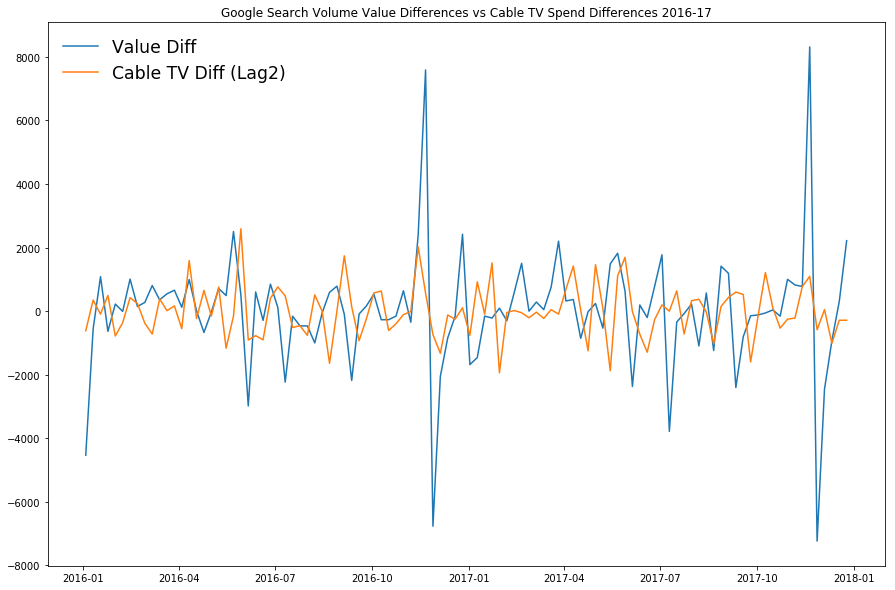

In [16]:
#Initialize a start date and end date
startdate = pd.to_datetime('2016-01-01').date()
enddate = pd.to_datetime('2017-12-31').date()

#Make a new dataframe of just 2016-17
two_years = adspend_trends_diff.loc[startdate:enddate]

#plot the lag and the target variable
dimensions = (15,10)
fig, (ax1) = pyplot.subplots(figsize=dimensions, sharex = 'all')
_ = ax1.plot(two_years.index, two_years['value_diff'], label = 'Value Diff')
_ = ax1.plot(two_years.index, two_years['CABLE TV_diff_lag2'], label = 'Cable TV Diff (Lag2)')
_ = ax1.set_title("Google Search Volume Value Differences vs Cable TV Spend Differences 2016-17")
leg = ax1.legend(frameon = False, fontsize = 'xx-large');

***
## Magazines
A longer lag for magazines makes the plot overlaying the Google Search Volume and magazine adspend pretty visually stimulating. The period at the beginning of 2016 and each Black Friday align pretty well for the two variables. This lag makes sense as the effect of a magazine ad takes some time to resonate. 

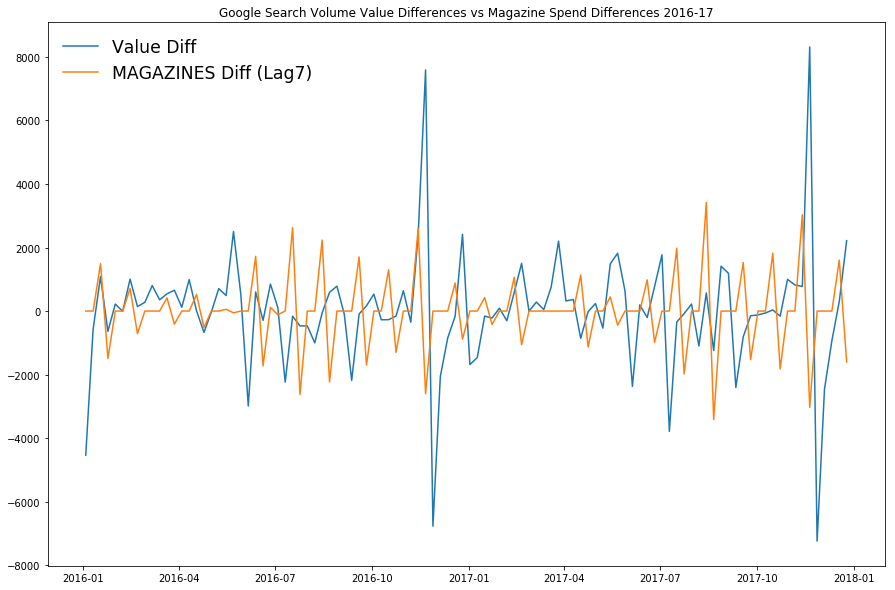

In [17]:
dimensions = (15,10)
fig, (ax1) = pyplot.subplots(figsize=dimensions, sharex = 'all')
_ = ax1.plot(two_years.index, two_years['value_diff'], label = 'Value Diff')
_ = ax1.plot(two_years.index, two_years['MAGAZINES_diff_lag7'], label = 'MAGAZINES Diff (Lag7)')
_ = ax1.set_title("Google Search Volume Value Differences vs Magazine Spend Differences 2016-17")
leg = ax1.legend(frameon = False, fontsize = 'xx-large');

***
## Network Radio
While network radio at a lag of 7 is most significant, this is not very intuitive. It seems that the effect of a radio advertisement should be more immediate than 7 weeks, and the chart below with a lag of 1 week has some interesting intervals. Below we can see that there is little variation in radio spend over the course of a year, however there are a few changes that line up well with the Google search volume changes. None of these times are notable holidays or dates with extreme Google search volume variation, but the relationship is interesting nonetheless. 

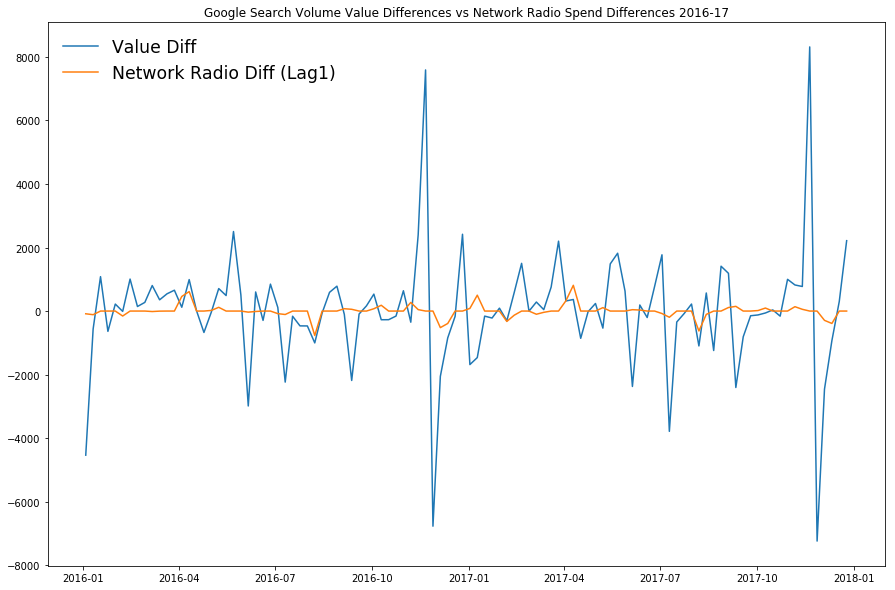

In [18]:
dimensions = (15,10)
fig, (ax1) = pyplot.subplots(figsize=dimensions, sharex = 'all')
_ = ax1.plot(two_years.index, two_years['value_diff'], label = 'Value Diff')
_ = ax1.plot(two_years.index, two_years['NETWORK RADIO_diff_lag1'], label = 'Network Radio Diff (Lag1)')
_ = ax1.set_title("Google Search Volume Value Differences vs Network Radio Spend Differences 2016-17")
leg = ax1.legend(frameon = False, fontsize = 'xx-large');

***
## Network TV
In looking at the below graph with a lag of 1, there are a few spots that follow each other to an astonishing degree, such as April 2016 to August 2016 as well as during a similar span of months during 2017. Network TV appears to be incredibly predictive during these times of year. 

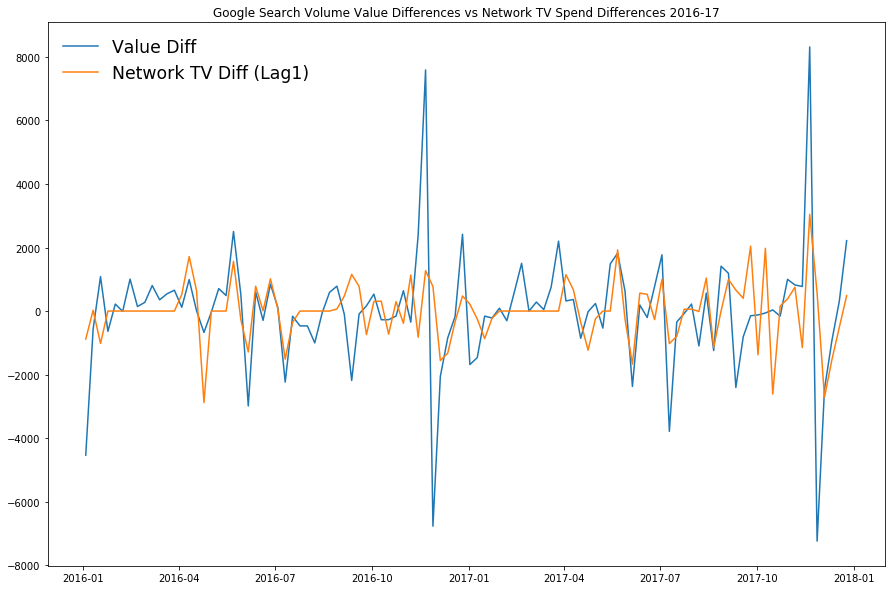

In [19]:
dimensions = (15,10)
fig, (ax1) = pyplot.subplots(figsize=dimensions, sharex = 'all')
_ = ax1.plot(two_years.index, two_years['value_diff'], label = 'Value Diff')
_ = ax1.plot(two_years.index, two_years['NETWORK TV_diff_lag1'], label = 'Network TV Diff (Lag1)')
_ = ax1.set_title("Google Search Volume Value Differences vs Network TV Spend Differences 2016-17")
leg = ax1.legend(frameon = False, fontsize = 'xx-large');

***
## Newspaper
As we can see in the graph below, newspaper spending doesn't vary or overlay much with Google search volume. There are a still a few spots where we can see that it aligns with Google search volume, and we have not used a lag at all here. For newspaper, this seems to make sense as after a new edition comes out, the previous days newspaper is seldomly looked at, leading to a more immediate effect rather than a lagged one. 

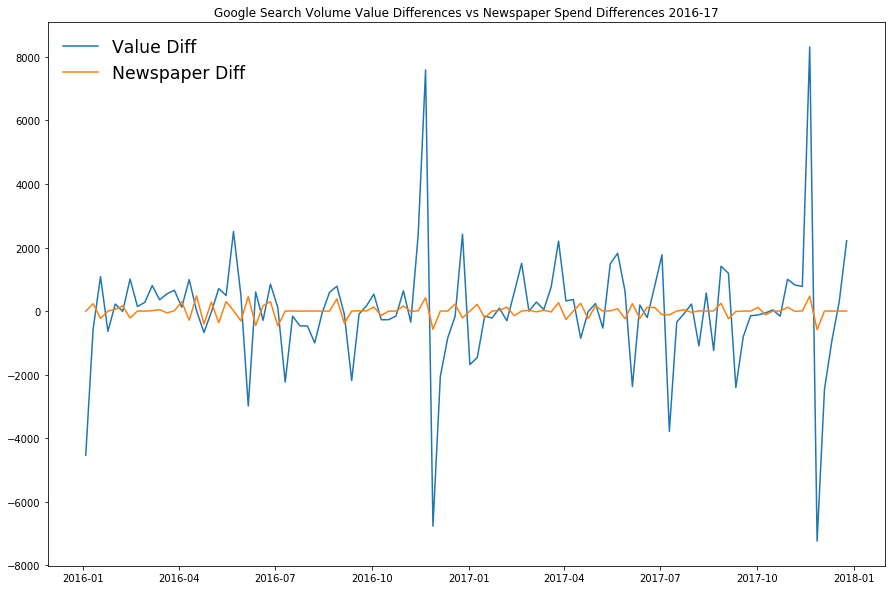

In [20]:
dimensions = (15,10)
fig, (ax1) = pyplot.subplots(figsize=dimensions, sharex = 'all')
_ = ax1.plot(two_years.index, two_years['value_diff'], label = 'Value Diff')
_ = ax1.plot(two_years.index, two_years['NEWSPAPER_diff'], label = 'Newspaper Diff')
_ = ax1.set_title("Google Search Volume Value Differences vs Newspaper Spend Differences 2016-17")
leg = ax1.legend(frameon = False, fontsize = 'xx-large');

## Total Spend
Spot TV was skipped over as there are not any interesting findings in the graph. Total spend captures many of the peaks in the graph, but there are also some conflicting points. Using the total adspend, a lag of 8 weeks shows to be predictive for many of Home Depot's biggest Google search volume dates. 

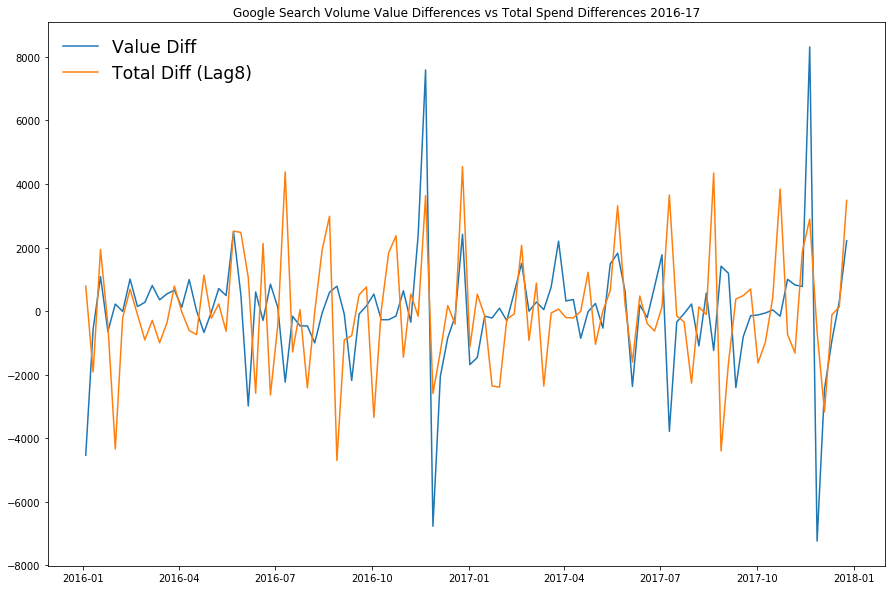

In [21]:
dimensions = (15,10)
fig, (ax1) = pyplot.subplots(figsize=dimensions, sharex = 'all')
_ = ax1.plot(two_years.index, two_years['value_diff'], label = 'Value Diff')
_ = ax1.plot(two_years.index, two_years['TOTAL_diff_lag8'], label = 'Total Diff (Lag8)')
_ = ax1.set_title("Google Search Volume Value Differences vs Total Spend Differences 2016-17")
leg = ax1.legend(frameon = False, fontsize = 'xx-large');

## Attempting to Further Improve our Forecast With Neural Network Methods

#### Moving away from the adspend data, we now use a convolutional neural network to forecast time series for Home Depot Google search volume

First, we load some of our required packages.

In [22]:
from __future__ import print_function
import os
import sys
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

This model, like many neural networks, uses Stochastic Gradient Descent (SGD) for optimization. In order for SGD to work best, values need to be scaled, preferrably in the range of (-1, 1). Here we use a (0, 1) scale.

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
homedepot['scaled_value'] = scaler.fit_transform(np.array(homedepot['value']).reshape(-1, 1))

Now we split the data into training and validation sets, using the data in order. Here we use the first 70% of the dates (everything before April 1, 2017) as the training set and the remaining 30% of dates as the validation set. 

In [24]:
split_date = startdate = pd.to_datetime('2017-04-01').date()
df_train = homedepot.loc[:split_date]
df_val = homedepot.loc[split_date:]

print('Shape of train set:', df_train.shape)
print('Shape of test set:', df_val.shape)

Shape of train set: (1273, 4)
Shape of test set: (549, 4)


Next, we need to define a function to get our data in the format that is needed in order for the neural network to process it. We then use the function to get our training and test sets in the proper format to feed to the model. For this model, we are using the previous 7 values of Google Search Volume in order to predict the next value. 

In [25]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.iloc[i-nb_timesteps:i]))  #collect the prior 7 values of the target variable
        y.append(ts.iloc[i])                       #collect the target variable
    X, y = np.array(X), np.array(y)
    return X, y

In [26]:
#Collect the proper training data 
X_train, y_train = makeXy(df_train['scaled_value'], 7)
print('Shape of train arrays:', X_train.shape, y_train.shape)

Shape of train arrays: (1266, 7) (1266,)


In [27]:
#Collect the proper validation data
X_val, y_val = makeXy(df_val['scaled_value'], 7)
print('Shape of validation arrays:', X_val.shape, y_val.shape)

Shape of validation arrays: (542, 7) (542,)


In [28]:
#X_train and X_val are reshaped to 3D arrays per the neural net requirements
X_train, X_val = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)),\
                 X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Shape of arrays after reshaping:', X_train.shape, X_val.shape)

Shape of arrays after reshaping: (1266, 7, 1) (542, 7, 1)


## Building the neural network with keras

In [29]:
import keras
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import ZeroPadding1D
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import AveragePooling1D
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


To describe what we are doing below, we first add the input layer so that the model understands our input. We then move to a zeropadding layer, which adds zeroes to the front and back of the numbers to ensure that the convolution layer will not reduce the dimensions of the output. Next we add the convolution layer and specify the number of filters, the length of the 1D convolution window, and the number of places to shift the convolution window. We also set use_bias to True. Next, our average pooling layer is added which downsamples the input by taking the average over three of the predictor values and moves over the predictor values by 1 timestep. Lastly, we add in the flatten layer and dropout layer to get the value that we want to predict and drop the other values that are originally returned. These layers then pass the output along to the output layer. 

Following the layer set up, we set up our model to optimize for MAE and to use the adaptive moment estimation algorithm (Adam) to optimize our weights. Adam is a very popular choice for training neural networks. We then take a quick look at the model we have built and are ready to fit the model!

In [30]:
input_layer = Input(shape=(7,1), dtype='float32')

zeropadding_layer = ZeroPadding1D(padding=1)(input_layer)

conv1D_layer = Conv1D(64, 3, strides=1, use_bias=True)(zeropadding_layer)

avgpooling_layer = AveragePooling1D(pool_size=3, strides=1)(conv1D_layer)

flatten_layer = Flatten()(avgpooling_layer)

dropout_layer = Dropout(0.2)(flatten_layer)

output_layer = Dense(1, activation='linear')(dropout_layer)


ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_absolute_error', optimizer='adam')#SGD(lr=0.001, decay=1e-5))
ts_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 1)              0         
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, 9, 1)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 64)             256       
_________________________________________________________________
average_pooling1d_1 (Average (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 321       
Total para

## Now we fit the model, also saving the weights in a separate folder when the fit improves

In [31]:
save_weights_at = os.path.join('keras_models', 'Google_search_1DConv_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
_ = ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Instructions for updating:
Use tf.cast instead.


Train on 1266 samples, validate on 542 samples
Epoch 1/20
1266/1266 [==============================] - 0s 382us/step - loss: 0.0768 - val_loss: 0.0602
Epoch 2/20
1266/1266 [==============================] - 0s 87us/step - loss: 0.0547 - val_loss: 0.0542
Epoch 3/20
1266/1266 [==============================] - 0s 103us/step - loss: 0.0504 - val_loss: 0.0525
Epoch 4/20
1266/1266 [==============================] - 0s 73us/step - loss: 0.0496 - val_loss: 0.0522
Epoch 5/20
1266/1266 [==============================] - 0s 103us/step - loss: 0.0489 - val_loss: 0.0569
Epoch 6/20
1266/1266 [==============================] - 0s 79us/step - loss: 0.0488 - val_loss: 0.0515
Epoch 7/20
1266/1266 [==============================] - 0s 100us/step - loss: 0.0489 - val_loss: 0.0552
Epoch 8/20
1266/1266 [==============================] - 0s 96us/step - loss: 0.0498 - val_loss: 0.0561
Epoch 9/20
1266/1266 [==============================] - 0s 87us/step - loss: 0.0484 - val_loss: 0.0514
Epoch 10/20
1266/1266 

Now that the model has been fit many times, we use the best model to predict the values of our validation set, calculate the R-squared of our predictions, and plot the time series of our predictions vs. the time series of reality.  

In [32]:
best_model = load_model(os.path.join('keras_models', 'Google_search_1DConv_weights.19-0.0494.hdf5'))
predictions_scaled = best_model.predict(X_val)
predictions = np.squeeze(scaler.inverse_transform(predictions_scaled))

In [33]:
from sklearn.metrics import r2_score

r2 = r2_score(df_val['value'].iloc[7:], predictions)
print('R-squared for the validation set:', round(r2, 4))

R-squared for the validation set: 0.4966


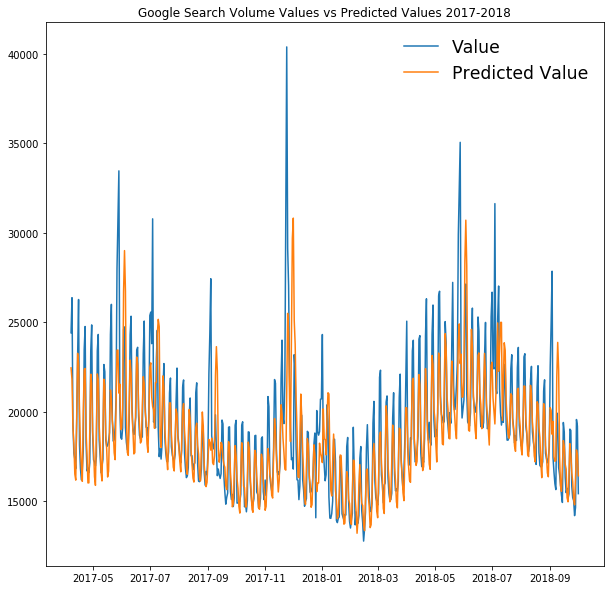

In [34]:
dimensions = (10,10)
fig, (ax1) = plt.subplots(figsize=dimensions, sharex = 'all')
_ = ax1.plot(df_val.index[7:], df_val['value'].iloc[7:].tolist(), label = 'Value')
_ = ax1.plot(df_val.index[7:], predictions, label = 'Predicted Value')
_ = ax1.set_title("Google Search Volume Values vs Predicted Values 2017-2018")
leg = ax1.legend(frameon = False, fontsize = 'xx-large');

Lastly, we examine the mean absolute error for our test set, which is considerably higher than our profit model. In looking at the graph and the residuals, it seems that the model often underestimates values and that the model struggles with holidays in comparison to the Prophet model. That being said, the model still comes in with an MAE that is less than 1/2 of the standard deviation of the target variable. Perhaps with more training data or by learning methods of dealing with holidays in a neural net, this model could result in a stronger performance. 

In [35]:
Actual = df_val['value'].iloc[7:].tolist()
results = pd.DataFrame({'prediction': list(predictions), 'Actual': Actual})
results['difference'] = results['prediction']-results['Actual']
results['absolute_residual'] = abs(results['difference'])
results['date'] = df_val.index.tolist()[7:]
print('===================================================')
print('                Validation Set MAE                  ')
print('===================================================')
print('               ', sum(results['absolute_residual'])/(len(df_val)-7))

print('=========================')
print('     Top 10 Residuals                    ')
print('=========================')
print(results.nlargest(10, 'absolute_residual')[['date','difference']].to_string(index=False))

                Validation Set MAE                  
                1542.0361037387377
     Top 10 Residuals                    
       date    difference
 2017-11-24 -19483.613692
 2017-11-23 -14810.450043
 2017-12-01  14027.779403
 2017-05-29 -12422.317833
 2018-05-28 -12363.275163
 2018-07-04 -12315.255581
 2017-11-30  12291.792511
 2017-07-04 -10491.657023
 2017-09-04  -9583.480445
 2018-09-03  -9110.789393


***

## Conclusions

Overall, it is clear that Home Depot has a few holidays every year that cause major increases in Google search volume. Additionally, the seasonality of their business as one that garners more interest in the spring and summer months and declining interest in the fall and winter months is clear. Taking a more granular approach, it is also quite clear that there is a weekly seasonality with higher search volumes on the weekends, which we would expect from a home improvement store.  While we can plan pretty well for holidays, they are still the most volatile and hardest to accurately predict days of the year. Our data has a positive trend and after controlling for holidays and holiday weekends in our Prophet model, we were able to get an MAE that is less than 1/5 of our target variable standard error. When looking at the Granger causality of lagged adspend variables and Google search volume, many significant patterns emerge, however a few are especially noteworthy. These can be seen by looking at an overlap of time series including both adspend data as well as Google search volume. Upon looking at these graphs, the most interesting relationships appear to be between cable and network tv with search volume. The overlap of total adspend and search volume was pretty interesting also. Moving away from adspend data and trying to use a neural network time series approach, it became clear that being able to account for holidays is extremely important to undertanding Home Depot's Google search volume with accuracy. 

There are many takeaways from this project and many strategic applications that could be employed by Home Depot. To summarize, by using Facebook Prophet, Home Depot can get a reasonably accurate estimate of their Google search volume for any given day, as well as a sound understanding of the trend and seasonality that their search volume exhibits. This would be useful for demand planning among other things, and with the continuation of data collection, Home Depot could likely get an even stronger model in the coming years. 